In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import LocalOutlierFactor
from numpy import ma
import math
import matplotlib
from matplotlib.pyplot import figure
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
%matplotlib inline
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from scipy.stats import multivariate_normal
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.utils import to_categorical
from keras.datasets import imdb
#from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from scikeras.wrappers import KerasClassifier
import keras.backend as K
from sklearn.model_selection import TimeSeriesSplit


from flask import Flask, request, jsonify
import joblib


In [2]:
data = pd.read_csv('stocks.csv')
data.head(10)

data['Ticker'].unique()
data.describe()
data.info()
data.shape
data.dtypes
data.select_dtypes(include=[np.number]).corr()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB


,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999626,0.999650,0.999176,0.999173,-0.547741
High,0.999626,1.000000,0.999654,0.999644,0.999640,-0.546175
Low,0.999650,0.999654,1.000000,0.999663,0.999661,-0.544590
Close,0.999176,0.999644,0.999663,1.000000,0.999999,-0.544194
Adj Close,0.999173,0.999640,0.999661,0.999999,1.000000,-0.544370
Volume,-0.547741,-0.546175,-0.544590,-0.544194,-0.544370,1.000000


In [3]:
data.isnull().sum()

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

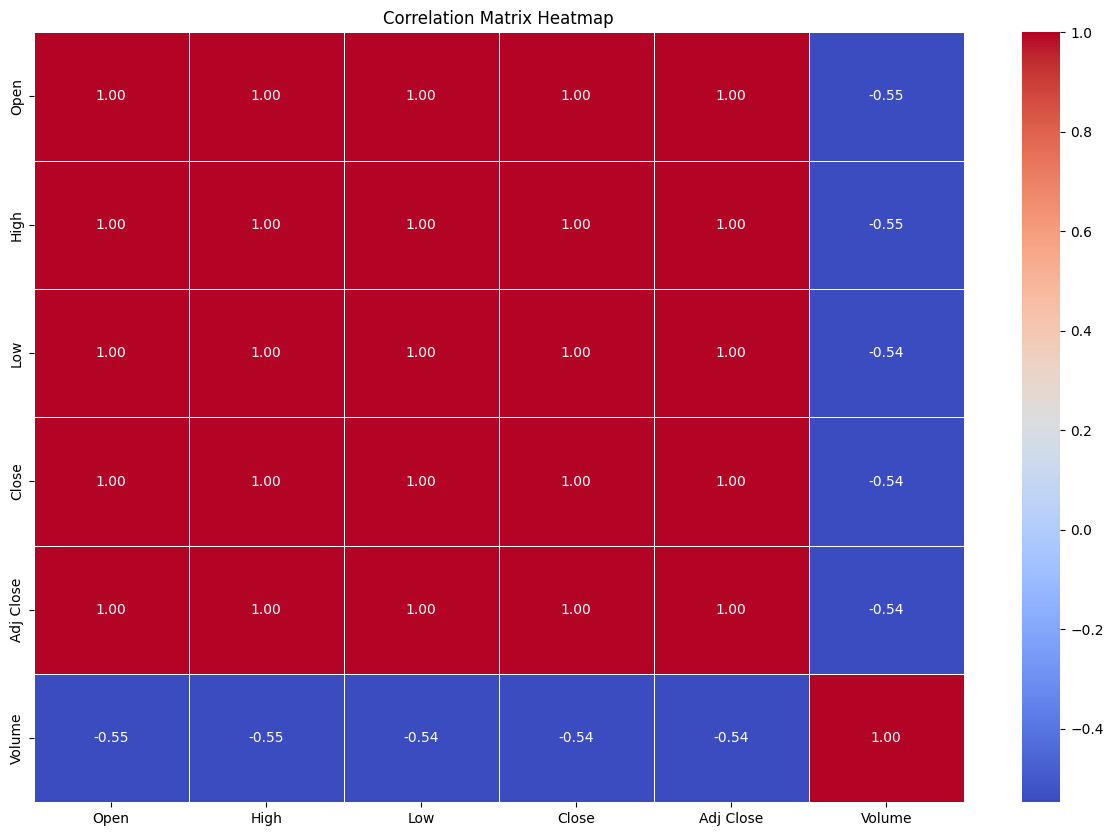

In [4]:
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [5]:
profile= ProfileReport(data, title="Stock Market Analysis")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|                                                                                            | 0/8 [00:00<?, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

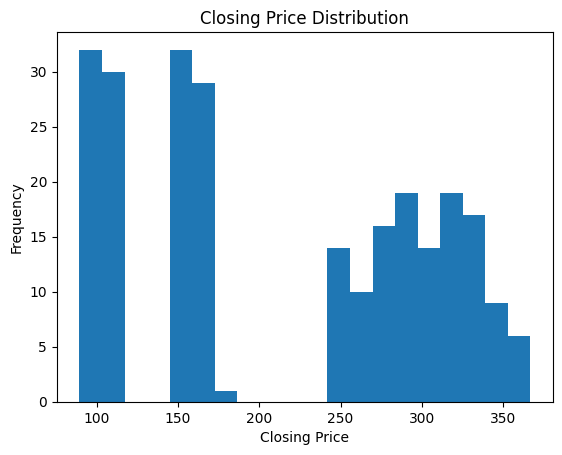

In [7]:
# the distribution of the closing prices to understand their range and frequency.
plt.hist(data['Close'], bins=20)
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.title('Closing Price Distribution')
plt.show()

Text(0.5, 1.0, 'Total Volume by Ticker')

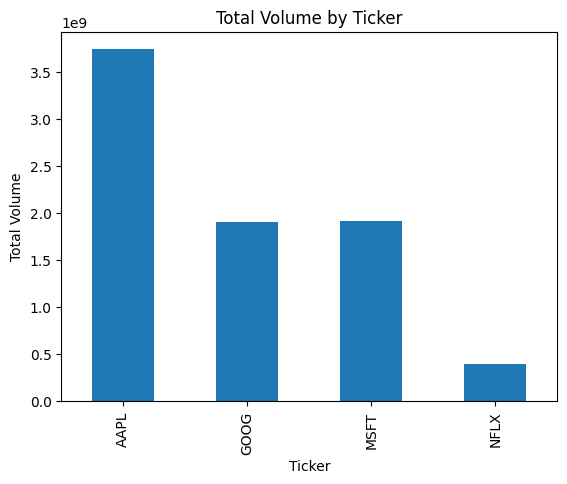

In [8]:
#the cumulative volume traded over time to observe any trends or spikes.
ticker_volume = data.groupby('Ticker')['Volume'].sum()
ticker_volume.plot(kind='bar')
plt.xlabel('Ticker')
plt.ylabel('Total Volume')
plt.title('Total Volume by Ticker')

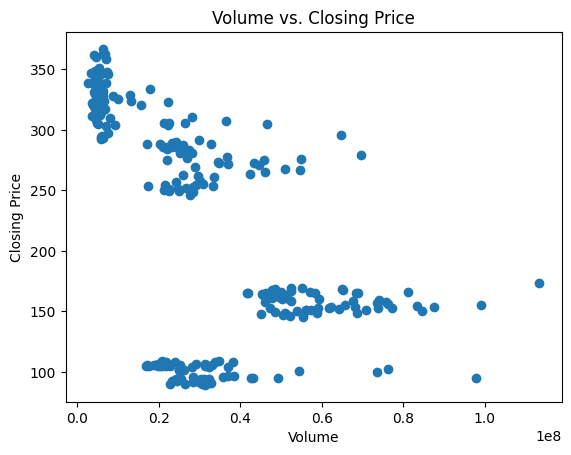

In [9]:
#Exploring the relationship between volume and closing prices, to identify any correlations.
plt.scatter(data['Volume'], data['Close'])
plt.xlabel('Volume')
plt.ylabel('Closing Price')
plt.title('Volume vs. Closing Price')
plt.show()

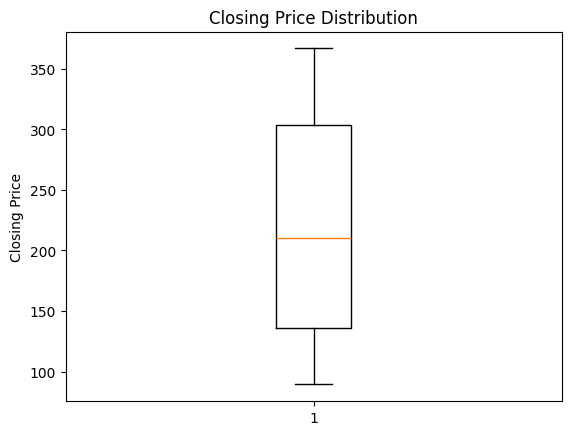

In [10]:
#Illustrating the distribution of the closing prices, including the median, quartiles, and outliers.
plt.boxplot(data['Close'])
plt.ylabel('Closing Price')
plt.title('Closing Price Distribution')
plt.show()

In [11]:
data.head(5)

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


In [12]:
# Create date-based features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Day_of_week'] = data['Date'].dt.dayofweek

# Create price change features
data['Daily_Return'] = data['Close'].pct_change()
data['Price_Change'] = data['Close'] - data['Open']
data['High_Low_Pct'] = (data['High'] - data['Low']) / data['Low'] * 100
data['Close_Open_Pct'] = (data['Close'] - data['Open']) / data['Open'] * 100

# Create moving averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()

# Create volatility measure
data['Volatility'] = data['Daily_Return'].rolling(window=5).std()

# Drop the first rows with NaN values from rolling calculations
data.dropna(inplace=True)

# Drop columns we won't use for modeling
data.drop(['Ticker', 'Date', 'Adj Close'], axis=1, inplace=True)

# Display the modified dataframe
print(data.head())

          Open        High         Low       Close    Volume  Year  Month  \
19  153.699997  154.029999  151.130005  151.600006  56182000  2023      3   
20  152.809998  153.470001  151.830002  152.869995  47204800  2023      3   
21  153.559998  154.539993  150.229996  150.589996  53833600  2023      3   
22  150.210007  150.940002  147.610001  148.500000  68572400  2023      3   
23  147.809998  153.139999  147.699997  150.470001  84457100  2023      3   

    Day  Day_of_week  Daily_Return  Price_Change  High_Low_Pct  \
19    7            1     -0.014496     -2.099991      1.918874   
20    8            2      0.008377      0.059998      1.080155   
21    9            3     -0.014915     -2.970001      2.868933   
22   10            4     -0.013879     -1.710007      2.255946   
23   13            0      0.013266      2.660004      3.683143   

    Close_Open_Pct        MA_5       MA_10       MA_20  Volatility  
19       -1.366292  149.536002  148.803001  150.680000    0.021429  
20

In [13]:
# Define features (X) and target (y)
X = data.drop(['Close'], axis=1)  # Features
y = data['Close']  # Target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Let's see the shapes of our datasets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (183, 16)
Testing set shape: (46, 16)


In [14]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Dictionary to store model performance
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    # Print results
    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Linear Regression Performance:
MSE: 0.0000
RMSE: 0.0000
MAE: 0.0000
R2 Score: 1.0000

Random Forest Performance:
MSE: 28.1345
RMSE: 5.3042
MAE: 4.9132
R2 Score: -0.0359

Gradient Boosting Performance:
MSE: 38.3923
RMSE: 6.1961
MAE: 5.6523
R2 Score: -0.4136

Support Vector Regression Performance:
MSE: 20656.6331
RMSE: 143.7242
MAE: 143.5560
R2 Score: -759.5489

Model Comparison:
                                    MSE          RMSE           MAE  \
Linear Regression          8.490613e-27  9.214452e-14  9.020803e-14   
Random Forest              2.813445e+01  5.304192e+00  4.913237e+00   
Gradient Boosting          3.839227e+01  6.196150e+00  5.652292e+00   
Support Vector Regression  2.065663e+04  1.437242e+02  1.435560e+02   

                                   R2  
Linear Regression            1.000000  
Random Forest               -0.035872  
Gradient Boosting           -0.413551  
Support Vector Regression -759.548888  


In [15]:

# Let's tune the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"\nBest parameters: {best_params}")

# Train the model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred = best_rf.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized Random Forest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Optimized Random Forest Performance:
RMSE: 5.3042
R2 Score: -0.0359


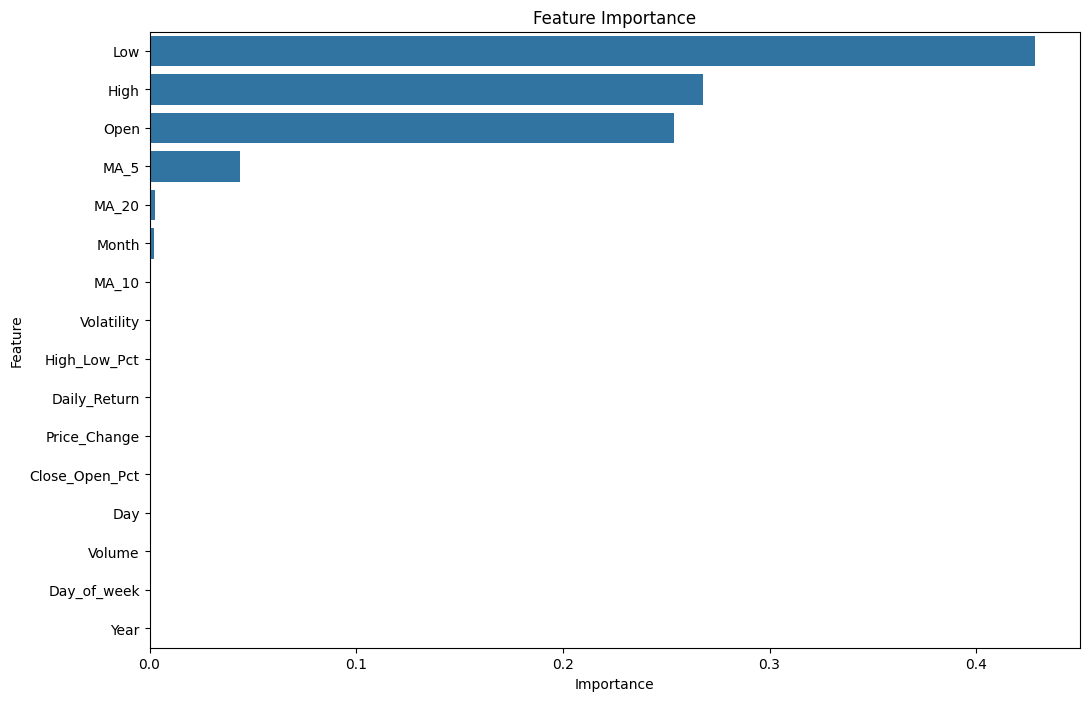

In [16]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [ ]:

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
cv_scores = []
for train_index, test_index in tscv.split(X_train_scaled):
    X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    best_rf.fit(X_train_cv, y_train_cv)
    y_pred_cv = best_rf.predict(X_test_cv)
    cv_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))

print(f"\nCross-validated RMSE scores: {cv_scores}")
print(f"Mean CV RMSE: {np.mean(cv_scores):.4f}")


Cross-validated RMSE scores: [np.float64(75.18476673813701), np.float64(18.69809415714691), np.float64(43.24135637874527), np.float64(6.360504841902947), np.float64(56.34710956142009)]
Mean CV RMSE: 39.9664


In [ ]:
app = Flask(__name__)

# Load the trained model and scaler
model = joblib.load('stock_price_rf_model.pkl')
scaler = joblib.load('stock_price_scaler.pkl')

@app.route('/')
def home():
    return '''
        <h2>Stock Price Prediction API</h2>
        <p>Send a POST request to <code>/predict</code> with JSON data.</p>
    '''

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        input_df = pd.DataFrame([data])
        input_scaled = scaler.transform(input_df)
        prediction = model.predict(input_scaled)
        return jsonify({'predicted_price': round(prediction[0], 2)})
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True, port=5001, use_reloader=False)



In [21]:
# Example of how to prepare new data for prediction
new_data = {
    'Open': 150.0,
    'High': 152.0,
    'Low': 149.5,
    'Volume': 5000000,
    'Year': 2023,
    'Month': 7,
    'Day': 15,
    'Day_of_week': 5,
    'Daily_Return': 0.01,
    'Price_Change': 1.5,
    'High_Low_Pct': 1.67,
    'Close_Open_Pct': 1.0,
    'MA_5': 149.8,
    'MA_10': 148.5,
    'MA_20': 147.2,
    'Volatility': 0.015
}

# Convert to DataFrame
new_df = pd.DataFrame([new_data])

# Scale the data
new_scaled = scaler.transform(new_df)

# Make prediction
predicted_price = best_rf.predict(new_scaled)
print(f"\nPredicted Closing Price: {predicted_price[0]:.2f}")


Predicted Closing Price: 151.84
